# Exploring Oversampling on the Income Dataset

[![Open In
Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/shaivimalik/medicine_preprocessing-on-entire-dataset/blob/main/notebooks/Exploring_Oversampling-Adult.ipynb)

## Introduction

This notebook explores the concept of data leakage, its consequences,
and prevention methods. We will investigate a specific type of data
leakage: **preprocessing on training and test set**. To demonstrate the
impact of data leakage, we will use the **Census Income dataset** for
income prediction, aiming to determine whether a person makes over 50K a
year using a Support Vector Machine (SVM) classifier with RBF kernel.

We will experiment with two modeling approaches:

-   **Oversampling the entire dataset followed by splitting**: This
    approach introduces data leakage due to potential information
    overlap between training and test sets after oversampling.

-   **Splitting the dataset before oversampling**: This approach helps
    mitigate data leakage by ensuring distinct training and test sets.

By comparing the performance of these models, we will examine the impact
of data leakage on model accuracy and generalisation.

Overview of the sections:

-   [Data Leakage](#data-leakage): We’ll explore data leakage and common
    errors.

-   [Retrieve the dataset](#retrieve-the-dataset): We will learn more
    about the Census Income dataset and retrieve it.

-   [SMOTE](#smote): We will implement the SMOTE oversampling technique.

-   [Training SVM - with Data
    Leakage](#training-svm---with-data-leakage): We will oversample the
    entire dataset before splitting it into training and test sets, and
    then train the SVM model.

-   [Training SVM - without Data
    Leakage](#training-svm---without-data-leakage): We will split the
    dataset into training and test sets, then oversample the training
    set before training the SVM model.

-   [Discussion](#discussion): We will evaluate the performance of
    models and discuss the importance of correct preprocessing.

## Data Leakage

Data leakage occurs when a model learns to recognise patterns or
relationships between the features and target variable during training
that don’t exist in the real-world data. Since these patterns won’t be
present in the real-world data about which the claims are made, models
with data leakage errors fail to generalise to unseen data[1]. Data
leakage includes errors such as:

-   **No test set:** If the model is trained and tested on the same
    data, it will perform exceptionally well on the test set, but it
    will fail on unseen data.

-   **Temporal leakage:** This occurs when data from the future is used
    to train a model created to predict future events.

-   **Duplicates in datasets:** If there are duplicate data points in
    both the training and test sets, the model can memorize these
    instances, leading to inflated performance metrics.

-   **Pre-processing on training and test set:** If pre-processing is
    performed on the entire dataset, information about the test set may
    leak into the training set.

-   **Model uses features that are not legitimate:** If the model has
    access to features that should not be legitimately available for
    use. For example, when information about the target variable is
    incorporated into the features used for training.

Data leakage leads to overly optimistic estimates of model performance.
It is also identified as the major cause behind the reproducibility
crisis in ML-Based science[2].

In this notebook, we will discover the consequences of pre-processing on
entire dataset, specifically oversampling, on model performance.

[1] Kapoor S, Narayanan A. Leakage and the reproducibility crisis in
machine-learning-based science. Patterns (N Y). 2023 Aug 4;4(9):100804.
doi: 10.1016/j.patter.2023.100804. PMID: 37720327; PMCID: PMC10499856.

[2] Nisbet, R., Elder, J., and Miner, G. Handbook of Statistical
Analysis and Data Mining Applications. Elsevier, 2009. ISBN
978-0-12-374765-5.

## Retrieve the dataset

The **Census Income dataset** is a widely used resource for income
prediction tasks. It was extracted from the **1994 US Census Bureau
database** by Ronny Kohavi and Barry Becker. This dataset provides
information on demographic, employment, and income attributes of
individuals. In this notebook, we will utilize a subset of 3000
instances from the adult database, obtained from the **UC Irvine Machine
Learning Repository**.

The dataset contains the following features and target variable:

| Column         | Type    | Data Type   |
|----------------|---------|-------------|
| age            | Feature | Integer     |
| workclass      | Feature | Categorical |
| fnlwgt         | Feature | Integer     |
| education      | Feature | Categorical |
| education-num  | Feature | Integer     |
| marital-status | Feature | Categorical |
| occupation     | Feature | Categorical |
| relationship   | Feature | Categorical |
| race           | Feature | Categorical |
| sex            | Feature | Binary      |
| capital-gain   | Feature | Integer     |
| capital-loss   | Feature | Integer     |
| hours-per-week | Feature | Integer     |
| native-country | Feature | Categorical |
| income         | Target  | Binary      |

The subset contains information about **3000** respondents, out of which
**2266** are categorised as **\<=50K** and **734** are categorised as
**\>50K**. Due to the inherent class imbalance, we will use the SMOTE
oversampling technique to balance the dataset before training a Support
Vector Machine with RBF kernel.

We start by importing the required libraries and loading the dataset.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import accuracy_score

In [ ]:
!wget -O ../adult.zip https://archive.ics.uci.edu/static/public/2/adult.zip
!unzip ../adult.zip -d ../

In [ ]:
# Load the adult dataset, specifying column names and limiting to 3000 rows
adult_data = pd.read_csv('../adult.data', names=['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship',
                                               'race', 'sex','capital-gain', 'capital-loss', 'hours-per-week', 'native-country','<=50K'], nrows=3000)
# Display the first few rows of the DataFrame
adult_data.head()

In [ ]:
# Extract the target variable '<=50K'
target_variable = adult_data['<=50K']
# Display the count of each class in the target variable
target_variable.value_counts()

In [ ]:
# Create a feature matrix by dropping the target variable column '<=50K'
feature_matrix = adult_data.drop(['<=50K'], axis=1)
# Display the first few rows of the feature matrix
feature_matrix.head()

In [ ]:
# Map the target variable values ' <=50K' and ' >50K' to numerical labels 0.0 and 1.0
y = target_variable.map({' <=50K': 0.0,' >50K': 1.0})
# Display the first few rows of the updated target variable
y.head()

In [ ]:
# Create features for 'Male' and 'Female' based on the 'sex' column
feature_matrix['Male'] = [1.0 if i==' Male' else 0.0 for i in feature_matrix['sex']]
feature_matrix['Female'] = [1.0 if i==' Female' else 0.0 for i in feature_matrix['sex']]

# Remove the 'fnlwgt' column 
feature_matrix.drop(['fnlwgt'], axis=1, inplace=True)

# Select columns with numerical data types
num_ix = feature_matrix.select_dtypes(include=['int64', 'float64']).columns

# Create a feature matrix 'X' containing only numerical features
X = feature_matrix[num_ix]

# Display the first few rows of X
X.head()

## SMOTE

**Synthetic Minority Over-sampling Technique (SMOTE)** is an
oversampling technique in which the minority class is oversampled by
creating synthetic samples[1]. The synthetic samples are generated with
the help of k minority class nearest neighbors. The algorithm generates
synthetic samples using the following steps:

-   For each minority class sample perform the steps N times, where N is
    the desired oversampling ratio:

    -   Identify its k-nearest neighbors (typically k=5) within the
        minority class.

    -   Randomly select one of these neighbors.

    -   Take the difference between the sample and its random nerest
        neighbor

    -   Multiply the difference by a random number between 0 and 1

    -   Add the resultant to the minority class sample to create the
        synthetic sample

> *Suppose N = 3 (meaning we’ll create three synthetic samples for each
> original minority sample)*
>
> *Minority Class Sample: \[9, 4, 11\]*
>
> *4 Minority Class Nearest Neighbors: \[11, 2, 13\], \[10, 5, 12\],
> \[8, 3, 11\], \[12, 3, 13\]*
>
> *Synthetic Sample 1:*
>
> \[9, 4, 11\] + 0.47 \* (\[10, 5, 12\] - \[9, 4, 11\])
>
> = \[9, 4, 11\] + 0.47 \* \[1, 1, 1\]
>
> = \[9, 4, 11\] + \[0.47, 0.47, 0.47\]
>
> = \[9.47, 4.47, 11.47\]
>
> *Synthetic Sample 2:*
>
> \[9, 4, 11\] + 0.91 \* (\[11, 2, 13\] - \[9, 4, 11\])
>
> = \[9, 4, 11\] + 0.91 \* \[2, -2, 2\]
>
> = \[9, 4, 11\] + \[1.82, -1.82, 1.82\]
>
> = \[10.82, 2.18, 12.82\]
>
> *Synthetic Sample 3:*
>
> \[9, 4, 11\] + 0.68 \* (\[8, 3, 11\] - \[9, 4, 11\])
>
> = \[9, 4, 11\] + 0.68 \* \[-1, -1, 0\]
>
> = \[9, 4, 11\] + \[-0.68, -0.68, 0\]
>
> = \[8.32, 3.32, 11\]

The above example in the form of Python code:

[1] Chawla, N.V., Bowyer, K.W., Hall, L.O. and Kegelmeyer, W.P., 2002.
SMOTE: synthetic minority over-sampling technique. Journal of artificial
intelligence research, 16, pp.321-357.

In [ ]:
# Number of synthetic samples to generate per minority sample
N = 3

minority_sample = np.array([9, 4, 11])

# K-nearest neighbors of the minority sample
knn = np.array([[11, 2, 13], [10, 5, 12], [8, 3, 11], [12, 3, 13]])

# List to store synthetic samples
syn_samples = []

for i in range(N):
    # Randomly select one of the k-nearest neighbors
    random_neighbor = knn[np.random.randint(0, knn.shape[0])]
    
    # Calculate the difference between the neighbor and the minority sample
    difference = random_neighbor - minority_sample
    
    # Create synthetic sample
    syn_sample = minority_sample + np.random.random() * difference
    
    print(f"Synthetic Sample {i+1}: {syn_sample}")
    
    # Add the synthetic sample to list
    syn_samples.append(syn_sample)

syn_samples = np.array(syn_samples)

In this way, SMOTE generates synthetic samples by utilizing minority
class samples and their k nearest neighbors. The number of synthetic
samples created from each minority sample is determined by the
oversampling ratio (N).

Given below is an implementation of SMOTE using `NumPy` and
`scikit-learn`. We calculate the value of N based on the imbalance
present in the input vectors. We generate the synthetic samples with the
help of the populate function present inside the sample method.

In [ ]:
class SMOTE(object):
  """
  This class implements the SMOTE (Synthetic Minority Oversampling Technique) algorithm
  for oversampling imbalanced datasets.
  """
  def __init__(self, n_neighbors=5, N=None):
    # Set random seed for reproducibility
    np.random.seed(20)
    self.k = n_neighbors
    # Initialize the NearestNeighbors object with Euclidean distance
    self.nn = NearestNeighbors(n_neighbors=self.k + 1, metric='euclidean')
    # Number of synthetic samples to generate for each minority sample
    self.N=N

  def sample(self, X, y):

    # Check if X and y are numpy arrays
    if not isinstance(X, np.ndarray):
      raise TypeError("X must be a numpy array, got", type(X).__name__,"instead")

    if not isinstance(y, np.ndarray):
      raise TypeError("X must be a numpy array, got", type(X).__name__,"instead")

    def populate(self, N, i, nnarray):

      nonlocal X
      nonlocal synthetic
      nonlocal new_index
      nonlocal parent
      nonlocal minority_X
      while N!=0:
        nn = np.random.randint(1,self.k+1)
        dif = minority_X[nnarray[:,nn]]-X[i]
        gap = np.random.random()
        synthetic[new_index] = X[i] + gap * dif
        parent.append([i,minority_idx[nnarray[:,nn]][0]])
        new_index += 1
        N -= 1

    # Identify unique classes and their counts
    unique_classes, class_counts = np.unique(y, return_counts=True)

    # Determine the minority and majority classes
    minority_class = unique_classes[np.argmin(class_counts)]
    majority_class = unique_classes[np.argmax(class_counts)]

    # Get indices of minority and majority class samples
    majority_idx = np.nonzero(y == majority_class)[0]
    minority_idx = np.nonzero(y == minority_class)[0]

    # Count of samples in each class
    ms = minority_idx.shape[0]
    ml = majority_idx.shape[0]

    print("\nSamples of minority class:",ms)
    print("Samples of majority class:", ml)

    # Calculate the number of synthetic samples needed
    if self.N is None: self.N = (ml -ms)//ms
    print("Number of synthetic samples to be generated:", self.N*ms,"\n")

    # Initialize the array for synthetic samples and parent tracking
    synthetic = np.zeros((self.N*ms, X.shape[1]))
    parent=[[i,i] for i in range(X.shape[0])]

    new_index = 0

    minority_X = X[minority_idx]

    # Fit nearest neighbors on minority samples
    self.nn.fit(minority_X)

    # Generate synthetic samples for each minority sample
    for i in minority_idx:
      nnarray = self.nn.kneighbors([X[i]], return_distance=False)
      populate(self, self.N, i, nnarray)

    # Combine original and synthetic samples
    return np.concatenate([X, synthetic], axis=0), np.concatenate([y, np.ones(self.N*ms)*minority_class], axis=0), np.array(parent)

## Training SVM - with Data Leakage

In this section, we scale the entire dataset using `MinMaxScaler` and
then oversample it using our implementation of SMOTE. We split the
resulting dataset into training and test sets using `ShuffleSplit`.
After splitting, Support Vector Machine classifier is trained on the
training set. To analyse data leakage, we calculate the number of
samples in training set derived from test set samples. We evaluate the
model on the test set, and report the accuracy.

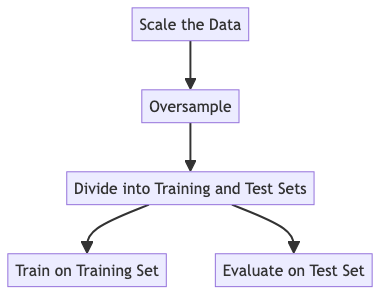

In [ ]:
# Training model with data leakage

# Dictionary to store results of the model with data leakage
leak_results = {'balanced': 0.0, 'correct': 0.0}

# Initialize MinMaxScaler for feature scaling
scaler = MinMaxScaler()

# Fit the scaler to the entire dataset (this is part of the data leakage)
scaler.fit(X)

# Transform the entire dataset using the MinMaxScaler
X_scaled = scaler.transform(X)

# Create SMOTE object
oversampler = SMOTE()

# Oversample the data using SMOTE
# This is done on the entire dataset, which is another source of data leakage
X_oversamp, y_oversamp, parent = oversampler.sample(X_scaled, y.to_numpy())

# Create ShuffleSplit object for splitting the dataset
rs = ShuffleSplit(n_splits=1, test_size=0.2, random_state=20)

# Split the oversampled dataset into training and test sets
train_index, test_index = next(rs.split(X_oversamp))
X_train, y_train = X_oversamp[train_index], y_oversamp[train_index]
X_test, y_test = X_oversamp[test_index], y_oversamp[test_index]

# Identify the synthetic samples in training set
train_syn = np.where(train_index >= X.shape[0])

# Count the number of synthetic samples in training set that were generated from test set samples
train_leak = np.sum(np.any(np.isin(parent[train_index][train_syn], test_index), axis=1))

# Print results of oversampling
print("Number of samples in training set derived from test set:", train_leak)
print("Percentage of training set derived from test set:", round(train_leak*100/len(train_index), 2), "%")

# Create and train SVM classifier
svm = SVC(kernel='rbf', C=10.0, gamma=1000.0, random_state=20)
svm.fit(X_train, y_train)

# Predict labels for the test set
y_pred = svm.predict(X_test)

# Evaluate model on test set
print("\n--- Evaluation with Test Set ---")
leak_results['balanced'] = accuracy_score(y_test, y_pred)
print("Accuracy:", leak_results['balanced'])

## Training SVM - without Data Leakage

In this section, the dataset is split into training and test sets using
`ShuffleSplit`. We scale the training set using `MinMaxScaler` and
oversample it using our implementation of SMOTE. A Support Vector
Machine (SVM) classifier is then trained on the oversampled training
data. To analyse data leakage, we calculate the number of samples in
training set derived from test set samples. The test set is scaled using
the statistics derived from the training set. The SVM model’s
performance is evaluated on both the original (imbalanced) and
oversampled test sets. The accuracy is reported for both test set
conditions.

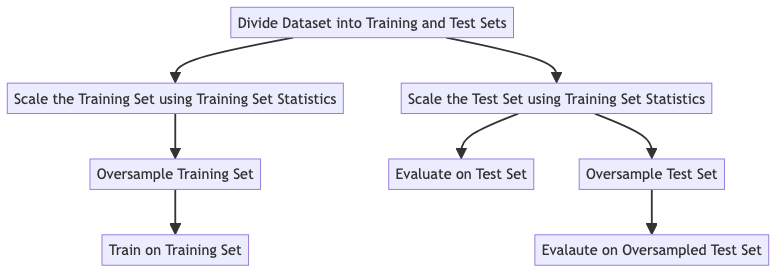

In [ ]:
# Training model without data leakage

# Dictionary to store results of the model without data leakage
cor_results={'balanced': 0.0, 'correct': 0.0}

# Create ShuffleSplit object for splitting the dataset
rs = ShuffleSplit(n_splits=1, test_size=0.2, random_state=20)

# Split the data into training and test sets
# This is done before any preprocessing to prevent data leakage
train_index, test_index = next(rs.split(X.to_numpy()))
X_train, y_train = X.to_numpy()[train_index], y.to_numpy()[train_index]
X_test, y_test = X.to_numpy()[test_index], y.to_numpy()[test_index]

# Initialize and fit the MinMaxScaler on training data only
scaler = MinMaxScaler()
scaler.fit(X_train)

# Transform both training and test sets using the scaler fitted on training data
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Create an instance of the SMOTE oversampler
oversampler = SMOTE()

# Oversample the training data only
X_train_oversamp, y_train_oversamp, parent_train = oversampler.sample(X_train, y_train)

# Identify the synthetic samples in training set
train_new = np.where(train_index >= X_train_oversamp.shape[0])

# Count the number of synthetic samples in training set samples generated from test set samples
leak = np.sum(np.any(np.isin(parent[train_index][train_new], test_index), axis=1))

# Print oversampling results
print("Number of samples in training set derived from test set:", leak)
print("Percentage of training set derived from test set:", leak*100/len(train_index), "%")

# Create and train SVM classifier on the oversampled training data
svm = SVC(kernel='rbf', C=10.0, gamma=1000.0, random_state=20)
svm.fit(X_train_oversamp, y_train_oversamp)

print("\n--- Evaluation with Oversampled Test Set (Not Recommended) ---")
# Oversample the test set (Note: This is not typically recommended)
X_test_oversamp, y_test_oversamp, parents_test = oversampler.sample(X_test, y_test)
y_pred_oversamp = svm.predict(X_test_oversamp)

# Calculate and print accuracy on oversampled test set
cor_results['balanced'] = accuracy_score(y_test_oversamp, y_pred_oversamp)
print("Accuracy:", cor_results['balanced'])

print("\n--- Correct Evaluation (Using Original Test Set) ---")
# Predict labels for the original test set
y_pred = svm.predict(X_test)

# Evaluate model on the original test set (This is the correct way to evaluate)
cor_results['correct'] = accuracy_score(y_test, y_pred)
print("Accuracy:",cor_results['correct'])

We create a barplot to visualise and compare the results obtained with
both models on test sets.

In [ ]:
# Define X-axis values for two bars
coordinates = np.arange(2)

# Set the width of each bar
width = 0.25

# Plot the bars for the data leakage results
# Shift these bars slightly to the left (-width/2)
plt.bar(coordinates - width/2, leak_results.values(), width, label='Data Leakage')

# Plot the bars for the correct results
# Shift these bars slightly to the right (+width/2)
plt.bar(coordinates + width/2, cor_results.values(), width, label='Without Data Leakage')

# Set the X-axis tick locations to be centered between each pair of bars
# Use the keys from cor_results as labels for these ticks
plt.xticks(coordinates, cor_results.keys())

# Set the Y-axis to range from 0 to 1
plt.ylim(0.0, 1.0)

# Add a legend
plt.legend()
# Display the plot
plt.show()

## Discussion

The results show that the model with data leakage achieved higher
accuracy compared to the model without data leakage. To provide a fair
comparison, we oversampled the test set in the second case, allowing us
to evaluate both models on a balanced set. However, modifying the test
set distribution is not recommended in practice, as the test set should
reflect the distribution of real-world data. To address this, we also
evaluated the model’s performance on the original, imbalanced test set,
providing a more accurate representation of its expected real-world
effectiveness.

| Metric | With Data Leakage | Without Data Leakage (oversampled test set) | Without Data Leakage (original test set) |
|:--------:|:----------:|:------------------------:|:-----------------------:|
| Accuracy | 81.43 | 61.17 | 72.5 |

As evident from the table, data leakage from the test set to the
training set has led to an overly optimistic measure of the model’s
performance. In practice, the performance differences due to data
leakage can be even more significant.

Best pratices:

-   Be mindful of how preprocessing is performed on the dataset.
-   Always split the dataset before applying preprocessing techniques.
-   Train the model using only the training set.
-   Apply the same preprocessing to the test set, but use statistics
    derived from the training set.
-   Evaluate the model’s performance using relevant metrics on the
    original, unmodified test set.

By following these practices, we can produce an accurate, unbiased
evaluation of our model, preventing data leakage and providing a more
reliable assessment of model performance in real-world scenarios.